# <center> Process of cleaning and analyzing horse racing data from Kaggle dataset "Horses for Courses"</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, ttest_1samp

%matplotlib inline

#To supress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#There are a lot of issues with the 'position_two' column, so I left it out.
#Furthermore, the 'position_again' column is much more consistent and has all relevant win/place information  

fields = ["position_again","bf_odds","venue_name","date","market_name","condition","barrier","handicap_weight","last_five_starts","prize_money","sex","age","jockey","jockey_sex","trainer","days_since_last_run","overall_starts","overall_wins","overall_places","track_starts","track_wins","track_places","firm_starts","firm_wins","firm_places","good_starts","good_wins","good_places","slow_starts","slow_wins","slow_places","soft_starts","soft_wins","soft_places","heavy_starts","heavy_wins","heavy_places","distance_starts","distance_wins","distance_places"]

df = pd.read_csv("horses.csv", skipinitialspace=True, usecols=fields, low_memory=False)

df.head()

,position_again,bf_odds,venue_name,date,market_name,condition,barrier,handicap_weight,last_five_starts,prize_money,...,slow_places,soft_starts,soft_wins,soft_places,heavy_starts,heavy_wins,heavy_places,distance_starts,distance_wins,distance_places
0,1.00,2.88,Echuca,2016-06-27,R3 1200m Mdn,HVY9,3.00,58.50,f3,2160.00,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
1,2.00,15.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,10.00,58.50,x80x2,21175.00,...,1.00,2.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00
2,3.00,95.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,6.00,56.50,79x00,28855.00,...,0.00,5.00,0.00,0.00,3.00,0.00,0.00,4.00,0.00,0.00
3,nan,20.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,2.00,56.50,f0,1475.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,nan,2.74,Echuca,2016-06-27,R3 1200m Mdn,HVY9,7.00,56.50,f4x,1215.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [3]:
#Used to identify condition types
df.condition.value_counts(dropna=False)

GOOD4    81874
SOFT5    29009
GOOD3    28712
NaN      22188
SOFT6    15648
SOFT7    12246
HVY8     11269
AWT      10281
HVY10     4876
HVY9      4165
GOOD      1023
FIRM2      384
HEAVY        5
Name: condition, dtype: int64

In [4]:
df.date = pd.to_datetime(df.date, format='%Y'+'-'+'%m'+'-'+'%d')

#removes numbers from end of 'condition' string
df.condition = df.condition.str.replace('\d+', '')

#renaming condition values so that they're uniform
df.condition = df.condition.str.replace('HVY', 'HEAVY')
df.condition = df.condition.str.replace('AWT', 'GOOD') #AWT equates to a Good surface under some weather conditions

#reverses 'last_five_starts' (originally written right-to-left) so that it's easier to read in the future
df.last_five_starts = df.last_five_starts.str[::-1]

## A prize_money_per_start column might be useful.

In [5]:
df.insert(10,'prize_money_per_start', df.prize_money/df.overall_starts)

df.drop('prize_money', axis=1, inplace=True)

df.head()

,position_again,bf_odds,venue_name,date,market_name,condition,barrier,handicap_weight,last_five_starts,prize_money_per_start,...,slow_places,soft_starts,soft_wins,soft_places,heavy_starts,heavy_wins,heavy_places,distance_starts,distance_wins,distance_places
0,1.00,2.88,Echuca,2016-06-27,R3 1200m Mdn,HEAVY,3.00,58.50,3f,2160.00,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
1,2.00,15.00,Echuca,2016-06-27,R3 1200m Mdn,HEAVY,10.00,58.50,2x08x,4235.00,...,1.00,2.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00
2,3.00,95.00,Echuca,2016-06-27,R3 1200m Mdn,HEAVY,6.00,56.50,00x97,2885.50,...,0.00,5.00,0.00,0.00,3.00,0.00,0.00,4.00,0.00,0.00
3,nan,20.00,Echuca,2016-06-27,R3 1200m Mdn,HEAVY,2.00,56.50,0f,1475.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,nan,2.74,Echuca,2016-06-27,R3 1200m Mdn,HEAVY,7.00,56.50,x4f,1215.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


## Creating general and conditions 'win_percent' and 'place_percent' columns:

In [6]:
#creates overall, track, and distance win_percent
#and place_percent columns and drops existing wins and places columns

columns_list = ["overall","track","distance"]

for x in columns_list:
    df[x+"_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df[x+"_place_percent"] = df[x+"_places"]/df[x+"_starts"]
  
    df.drop([x+'_starts', x+'_wins', x+'_places'], axis=1, inplace=True)

In [7]:
#creates a win_percent and place_percent column for the current condition of the track

df.loc[df.condition.isna(), "condition_win_percent"] = np.nan

condition_list = ["firm","good","slow","soft","heavy"]

for x in condition_list:    
    
    df.loc[df.condition.str.lower() == x, "condition_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df.loc[df.condition.str.lower() == x, "condition_place_percent"] = df[x+"_places"]/df[x+"_starts"]
    
    df.drop([x+'_starts', x+'_wins', x+'_places'], axis=1, inplace=True)

# Condition column is not necessary now that there are condition win and place percent columns 
df.drop('condition', axis=1, inplace=True)

# Replaces infinity (zero division) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

## Cleaning data by removing races with missing win and/or place values in 'position_again' column:

In [8]:
#Used groupby to create indices by which to sort the re-indexed dataframes below, like df_indexed and df_cleaned1
df_grouped = df.groupby(['date','venue_name','market_name'])

#Drops all groups/races in 'position_again' column where sum of values [1st, 2nd, 3rd] don't add to 3 or 6
#i.e. 1+2 and 1+2+3
index_list1 = df_grouped.position_again.sum(dropna=False).where(lambda x:(x == 3) | (x == 6)).dropna().index

df_indexed = df.set_index(['date','venue_name','market_name'])

df_cleaned1 = df_indexed.loc[index_list1]

In [9]:
df_grouped2 = df_cleaned1.groupby(['date','venue_name','market_name'])

#Eliminates remaining errors in 'position_again' column by making sure that there isn't a single 3rd-place finish
index_list2 = df_grouped2.position_again.count().where(lambda x:x > 1).dropna().index

In [10]:
df_cleaned2 = df_cleaned1.loc[index_list2]

df_cleaned2.head()

position_again  bf_odds  barrier  \
date       venue_name market_name                                        
2016-06-27 Echuca     R10 1400m Hcap            1.00    18.50    12.00   
                      R10 1400m Hcap            2.00    16.50     8.00   
                      R10 1400m Hcap            3.00    11.50     1.00   
                      R10 1400m Hcap             nan    19.00     5.00   
                      R10 1400m Hcap             nan     7.60     7.00   

                                      handicap_weight last_five_starts  \
date       venue_name market_name                                        
2016-06-27 Echuca     R10 1400m Hcap            57.50            86x01   
                      R10 1400m Hcap            59.00            6378x   
                      R10 1400m Hcap            58.50            430x5   
                      R10 1400m Hcap            58.50            44460   
                      R10 1400m Hcap            58.50            411x3   

                                      prize_money_per_start      sex  age  \
date       venue_name market_name                                           
2016-06-27 Echuca     R10 1400m Hcap                2742.12     Mare 6.00   
                      R10 1400m Hcap                2862.08  Gelding 5.00   
                      R10 1400m Hcap                2782.75  Gelding 5.00   
                      R10 1400m Hcap                4979.39  Gelding 6.00   
                      R10 1400m Hcap                4865.00     Mare 4.00   

                                          jockey jockey_sex  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap    J.R.TODD       Male   
                      R10 1400m Hcap   R.MALONEY       Male   
                      R10 1400m Hcap     M.PEGUS       Male   
                      R10 1400m Hcap    H.COFFEY       Male   
                      R10 1400m Hcap  C.J PARISH       Male   

                                                             trainer  \
date       venue_name market_name                                      
2016-06-27 Echuca     R10 1400m Hcap  MICHAEL CORNISH & DONNA GASKIN   
                      R10 1400m Hcap                 DAVID BRIDEOAKE   
                      R10 1400m Hcap                     GARY SHERER   
                      R10 1400m Hcap                    AUSTY COFFEY   
                      R10 1400m Hcap                  BRENDON HEARPS   

                                      days_since_last_run  \
date       venue_name market_name                           
2016-06-27 Echuca     R10 1400m Hcap                16.00   
                      R10 1400m Hcap                18.00   
                      R10 1400m Hcap                13.00   
                      R10 1400m Hcap                16.00   
                      R10 1400m Hcap                13.00   

                                      overall_win_percent  \
date       venue_name market_name                           
2016-06-27 Echuca     R10 1400m Hcap                 0.15   
                      R10 1400m Hcap                 0.17   
                      R10 1400m Hcap                 0.10   
                      R10 1400m Hcap                 0.10   
                      R10 1400m Hcap                 0.33   

                                      overall_place_percent  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap                   0.15   
                      R10 1400m Hcap                   0.17   
                      R10 1400m Hcap                   0.30   
                      R10 1400m Hcap                   0.16   
                      R10 1400m Hcap                   0.33   

                                      track_win_percent  track_place_percent  \
date       venue_name market_name                                              
2016-06-27 Echuca     R10 1400m Hcap               0.30

In [11]:
df_grouped3 = df_cleaned2.groupby(['date','venue_name','market_name'])

# Number of usable races:
len(df_grouped3)

22125

## Next, I create an 'average_weight' column for each race to create a weight_minus_average column and drop the handicap_weight column.

In [12]:
#Creates weight_minus_average column and drops 'handicap_weight' column
average_weight = df_grouped3.handicap_weight.transform('mean')

df_cleaned2.insert(4,'average_weight',average_weight)

df_cleaned2.insert(5,'weight_minus_average', df_cleaned2.handicap_weight - df_cleaned2.average_weight)

df_cleaned2.drop(['handicap_weight','average_weight'], axis=1, inplace=True)

df_cleaned2.head()

position_again  bf_odds  barrier  \
date       venue_name market_name                                        
2016-06-27 Echuca     R10 1400m Hcap            1.00    18.50    12.00   
                      R10 1400m Hcap            2.00    16.50     8.00   
                      R10 1400m Hcap            3.00    11.50     1.00   
                      R10 1400m Hcap             nan    19.00     5.00   
                      R10 1400m Hcap             nan     7.60     7.00   

                                      weight_minus_average last_five_starts  \
date       venue_name market_name                                             
2016-06-27 Echuca     R10 1400m Hcap                 -0.62            86x01   
                      R10 1400m Hcap                  0.88            6378x   
                      R10 1400m Hcap                  0.38            430x5   
                      R10 1400m Hcap                  0.38            44460   
                      R10 1400m Hcap                  0.38            411x3   

                                      prize_money_per_start      sex  age  \
date       venue_name market_name                                           
2016-06-27 Echuca     R10 1400m Hcap                2742.12     Mare 6.00   
                      R10 1400m Hcap                2862.08  Gelding 5.00   
                      R10 1400m Hcap                2782.75  Gelding 5.00   
                      R10 1400m Hcap                4979.39  Gelding 6.00   
                      R10 1400m Hcap                4865.00     Mare 4.00   

                                          jockey jockey_sex  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap    J.R.TODD       Male   
                      R10 1400m Hcap   R.MALONEY       Male   
                      R10 1400m Hcap     M.PEGUS       Male   
                      R10 1400m Hcap    H.COFFEY       Male   
                      R10 1400m Hcap  C.J PARISH       Male   

                                                             trainer  \
date       venue_name market_name                                      
2016-06-27 Echuca     R10 1400m Hcap  MICHAEL CORNISH & DONNA GASKIN   
                      R10 1400m Hcap                 DAVID BRIDEOAKE   
                      R10 1400m Hcap                     GARY SHERER   
                      R10 1400m Hcap                    AUSTY COFFEY   
                      R10 1400m Hcap                  BRENDON HEARPS   

                                      days_since_last_run  \
date       venue_name market_name                           
2016-06-27 Echuca     R10 1400m Hcap                16.00   
                      R10 1400m Hcap                18.00   
                      R10 1400m Hcap                13.00   
                      R10 1400m Hcap                16.00   
                      R10 1400m Hcap                13.00   

                                      overall_win_percent  \
date       venue_name market_name                           
2016-06-27 Echuca     R10 1400m Hcap                 0.15   
                      R10 1400m Hcap                 0.17   
                      R10 1400m Hcap                 0.10   
                      R10 1400m Hcap                 0.10   
                      R10 1400m Hcap                 0.33   

                                      overall_place_percent  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap                   0.15   
                      R10 1400m Hcap                   0.17   
                      R10 1400m Hcap                   0.30   
                      R10 1400m Hcap                   0.16   
                      R10 1400m Hcap                   0.33   

                                      track_win_percent  track_place_percent  \
date       venue_name market_name                                              
2016-06-27 Echuca   

In [13]:
df_grouped3 = df_cleaned2.groupby(['date','venue_name','market_name'])

## The first thing to do is test which features are significant.

## For jockey gender:

#### Overall percentage of men and women in races where both are represented:

In [14]:
#Drops races where there is only one jockey gender, meaning that the other gender can't win
jockey_sex_population = df_grouped3.jockey_sex.value_counts(normalize=True,dropna=False).where(lambda x: x != 1).dropna()

#Finds mean percent of jockey genders in races
jockey_sex_population.mean(level=3)

jockey_sex
Male     0.75
Female   0.25
Name: jockey_sex, dtype: float64

In [15]:
jockey_sex_population_indices = jockey_sex_population.index

jockey_sex_population_cleaned = df_cleaned1.loc[jockey_sex_population_indices].drop_duplicates()

#### Total male and female jockeys in races where both are represented
#### Finding the total a different way:

In [16]:
jockey_sex_population_cleaned.jockey_sex.value_counts(dropna=False,normalize=True)
#Yields same result as previous total:

Male     0.75
Female   0.25
NaN      0.00
Name: jockey_sex, dtype: float64

#### Win percentage of those races:

In [17]:
#Isolates wins in races with both jockey genders represented
jockey_sex_win_indices = jockey_sex_population_cleaned.position_again.apply(lambda x: x == 1)

jockey_sex_population_cleaned[jockey_sex_win_indices].jockey_sex.value_counts(normalize=True,dropna=False)

Male     0.79
Female   0.21
NaN      0.00
Name: jockey_sex, dtype: float64

#### Ensuring that races counted were same for both percentage values:

In [18]:
#Number of races for both previous percentages
#followed by the number of races there should be (given by number of first-place finishes): 

print(len(jockey_sex_population_cleaned.groupby(['date','venue_name','market_name'])))

print(len(jockey_sex_population_cleaned[jockey_sex_win_indices].jockey_sex.groupby(['date','venue_name','market_name'])))

jockey_sex_population_cleaned.position_again.value_counts()

16630
16630


2.00    16630
1.00    16630
3.00    14278
Name: position_again, dtype: int64

### Using a proportion z-test, I find that jockey gender is significant

## For horse gender:

In [19]:
#Removes races where only one horse gender is represented
horse_gender_population = df_grouped3.sex.value_counts(normalize=True,dropna=False).where(lambda x: x != 1).dropna()

#Takes average percentage of each gender in races
#In this case, this method of finding the general horse gender distribution overrepresents genders that are rare 
horse_gender_population.mean(level=3)

sex
Mare      0.32
Gelding   0.60
Filly     0.27
Colt      0.19
Horse     0.11
Unknown   0.09
Name: sex, dtype: float64

In [20]:
horse_gender_population_indices = horse_gender_population.index

horse_gender_population_cleaned = df_cleaned1.loc[horse_gender_population_indices].drop_duplicates()

In [21]:
#General percentage of horse genders for races where multiple genders are represented  
horse_gender_population_cleaned.sex.value_counts(dropna=False,normalize=True)

Gelding   0.57
Mare      0.27
Filly     0.13
Colt      0.03
Horse     0.01
NaN       0.00
Unknown   0.00
Name: sex, dtype: float64

In [22]:
horse_gender_win_indices = horse_gender_population_cleaned.position_again.apply(lambda x: x == 1)

print('Total wins:', horse_gender_population_cleaned[horse_gender_win_indices].sex.value_counts(dropna=False).sum())

horse_gender_population_cleaned[horse_gender_win_indices].sex.value_counts(dropna=False)

Total wins: 17566


Gelding    10015
Mare        4200
Filly       2447
Colt         715
Horse        187
Unknown        1
NaN            1
Name: sex, dtype: int64

#### Pearson's chi-squared test:

In [24]:
observed = [10015,4200,2447,715,187]
expected_percentages = [.57,.27,.13,.03,.01]
expected = [x*17564 for x in expected_percentages] #17564 removes the two anomalies (the Unknown and NaN genders)

test_stat1, p_value1 = chisquare(observed, expected)

p_value1

1.2744604302622612e-29

### Using the Pearson's chi-squared test for both ways of finding population, I find horse gender is significant 

## For horse weight, using weight_minus_average:

In [25]:
#number of NaN values in 'weight_minus_average' column
df_grouped3.weight_minus_average.apply(lambda x:x.isna()).sum()

26018

In [26]:
general_win_indices = df_grouped3.position_again.apply(lambda x: x == 1)

#average weight difference for winners
df_cleaned2[general_win_indices].weight_minus_average.describe()

data2 = df_cleaned2[general_win_indices].weight_minus_average.dropna().values

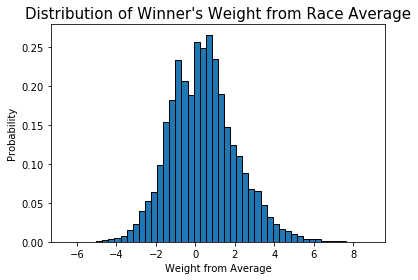

In [28]:
plt.title("Distribution of Winner's Weight from Race Average", fontsize=15)
plt.hist(data2, density=True, bins=50, edgecolor='k')
plt.xlabel('Weight from Average')
plt.ylabel('Probability');

#### 1 sample T-test:

In [29]:
test_stat2, p_value2 = ttest_1samp(data2, 0)

p_value2

5.65250989610721e-229

### Using a 1-sample T-test, I find that horse weight is significant

## For prize money, using prize_money_per_start: